# AI_campus_ProstateSeg 
# Module 7: Unsupervised Image Segmentation Using K-means clustering
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

This notebook walks through unsupervised image segmentation using K-means, an unsupervised clustering algorithm. In unsupervised machine learning, a model learns patterns from the data itself without relying on any external supervisory signal in the form of class labels, which in this case are the segmentation masks corresponding to each image. The K-means algorithm utilizes euclidean distance to assign different data points to one of a few fixed number of clusters (a user set hyper-parameter), which are represented by centroids (a representative point in a cluster, usually the average of coordinates in a cluster). Since our images have 3 channels (Red, Gree, and Blue), each location/point in the image can be featurized as a 3-dimensional vector, where the Red, Green and Blue pixel values that define it are stored. Then, the K-means algorithm can be applied to the image, expressed as a (N, D) matrix. Where N is the number of points in the image, and D corresponds to the number of pixel values that define each point in the image, which is 3 in case of RGB images. In case of a tile of size (224, 224, 3), we reshape the tensor to be of dimensionality (224 * 224, 3) = (50176, 3), and apply the K-means clustering algorithm to it. The K-means algorithm assigns a class label (expressed as integers) to each of the points, in a similar fashion as the segmentation mask does. The number of class labels that the k-means algorithm classifies the image points into is a hyper-parameter (k). 

## 1. Import the necessary packages

In [505]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch
import torchvision.transforms as transforms
import cv2

from PIL import Image
from typing import List, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset
from dataclass import ToyPANDASDataset
from torchvision.transforms import functional as F
from scipy.stats import entropy
from normalizers import ChannelWiseMinMaxNormalizer
from sklearn.cluster import KMeans

## 2. Define folder and subdirectory folder names

In [136]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print contents

In [137]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [138]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [139]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

## 4. Plot some random signal-dense tiles along with their class distributions

In [140]:
mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_files[8]))
image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_files[8]))

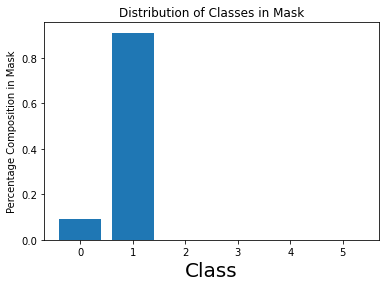

Percentage of 0, background (non tissue) or unknown: 0.09
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.91
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


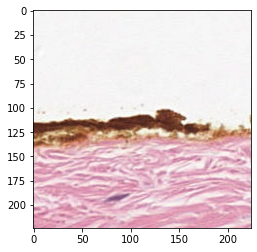

In [141]:
putil.plot_tile_by_first_class_occurance(image = image,
                                         mask = mask,
                                         pivot_class = 1)

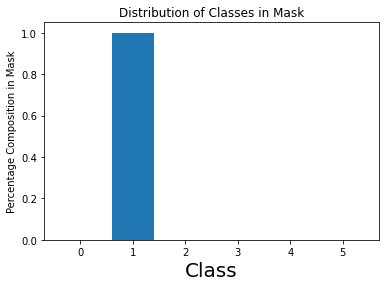

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 1.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


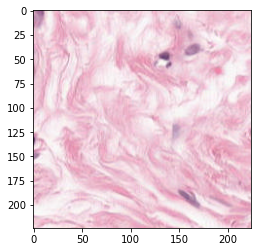

In [142]:
putil.plot_tile_by_first_class_occurance(image = image,
                                         mask = mask,
                                         pivot_class = 2)

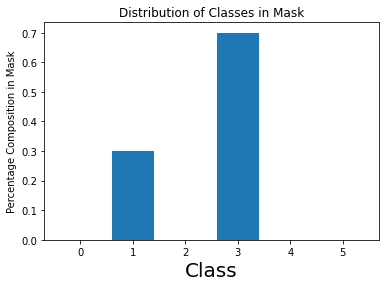

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.3
Percentage of 3, cancerous epithelium (Gleason 3): 0.7
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


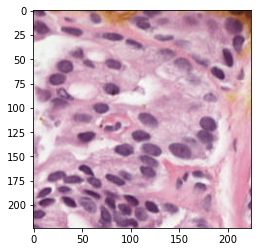

In [143]:
putil.plot_tile_by_first_class_occurance(image = image,
                                         mask = mask,
                                         pivot_class = 3)

## 5. Mine tiles with diverse representation of classes from each of the image-mask pairs

In case of the 224 by 224 tiles plotted above, only one of the five classes dominate the image or mask. In the first tile plotted above, stroma is 91%. In the second tile, stroma is almost 100%. In the third tile, cancerous epithelium is 70% and stroma is 30%. For the purpose of performing k-means segmentation, let us narrow down to tiles that feature a fair representation of all classes available in the image. To do so, we will calculate the entropy of the distribution of classes in a tile, and then find the tile with the highest entropy in the distribution of classes. This way, we can extract tiles with a good spread of classes available. The following function filters for the highest entropy tile in a given mask and image pair. 

In [589]:
def mine_highest_entropy_tile(image: np.ndarray,
                              mask: np.ndarray,
                              tile_size: int = 512) -> Tuple[float, float, np.ndarray, np.ndarray, List[float]]:
    """
    Mine highest entropy tile from an image and mask pair. The tile will have the
    highest entropy with respect to the distribution of classes present in the
    corresponding mask. The algorithm will repetitively calculate the entropy
    for each tile and update the max_entropy_tile and max_entropy_tile_mask as
    and when a tile with higher entropy is encountered. 
    
    Parameters
    -----------
    image: np.ndarray
        The image of arbitrary size
    
    mask: np.ndarray
        The mask with the same dimensionality
        as the image.
    
    tile_size: int
        The size of the square tiles to extract
        from the image. (Default = 512)
    
    Returns
    --------
    Tuple[float, float, np.ndarray, np.ndarray, List[float]]
    
    Returns the following from the tile-wise scan:
    
    max_entropy: float
        The maximum entropy of all the tiles of size tile_size x tile_size
        that are available in the image.
    
    min_entropy: float
        The minimum entropy of all the tiles of size tile_size x tile_size
        that are available in the image.
    
    max_entropy_tile: np.ndarray
        The maximum entropy tile from all the tiles scanned. This is 
        a numpy array of size tile_size x tile_size. 
    
    max_entropy_tile_mask: np.ndarray
        The maximum entropy tile mask scanned from all the tile masks.
        It has the same coordinates as the max_entropy_tile, and is
        of shape tile_size x tile_size. 
    
    tile_class_distribution_entropies: List[float]
        The entropy values of all the tiles scanned. 
    """
    
    max_entropy = -np.inf
    max_entropy_tile = None
    max_entropy_tile_mask = None
    n_tiles_scanned = 0
    available_classes = list(putil.enlist_class_presence(mask))
    tile_class_distribution_entropies = []
    
    R, C, n_channels = image.shape
    for i in range(0, R, tile_size):
        for j in range(0, C, tile_size):
            try:
                tile = image[i: i + tile_size, j: j + tile_size, :]
                if tile.shape == (tile_size, tile_size, n_channels):
                    n_tiles_scanned += 1
                    tile_mask = mask[i: i + tile_size, j: j + tile_size, :]
                    class_distribution = putil.summarize_class_distribution(tile_mask)
                    current_tile_entropy = entropy(list(class_distribution.values()))
                    tile_class_distribution_entropies.append(current_tile_entropy)
                    
                    if current_tile_entropy > max_entropy:
                        max_entropy = current_tile_entropy
                        max_entropy_tile = tile
                        max_entropy_tile_mask = tile_mask
            except IndexError:
                print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
    
    min_entropy = min(tile_class_distribution_entropies)
    assert max_entropy == max(tile_class_distribution_entropies)
    
    max_entropy_tile_classes = set(list(putil.enlist_class_presence(max_entropy_tile_mask)))
    
    print(f"Number of {tile_size}-sized tiles scanned: {n_tiles_scanned}")
    
    if max_entropy_tile_classes != set(available_classes):
        print("Not all available classes in mask are represented in the maximum entropy tile")
        
    return max_entropy, min_entropy, max_entropy_tile, max_entropy_tile_mask, tile_class_distribution_entropies

### 6. Write function to draw mask on an image given a boolean mask and class labels

In [618]:
def draw_mask(image: np.ndarray, 
              mask: np.ndarray,
              color_rgb_list: List[int] = [0, 255, 0]):
    
    """
    Function to draw mask on an image based on the
    mask given (mask). The mask will be translucent
    green given the default color in color_rgb_list = [0, 225, 0]
    
    Parameters
    -----------
    image: np.ndarray
        The image over which the mask is to be overlayed
    
    mask: np.ndarray
        The mask that is to be overlayed on the image. 
        This mask must be boolean (containing only True or False)
        
    color_rgb_list: List[int]
        The RGB pixel configuration of the color of the translucent
        mask to overlay on the image. 
        Default = [0, 255, 0] (green)
    
    Returns
    ---------
    np.ndarray
        The image with the colored mask overlaid along the 
        pixel locations which indicate True in the mask. 
    
    """
    
    masked_image = image.copy()
    masked_image = np.where(mask.astype(int),
                            np.array(color_rgb_list, dtype='uint8'),
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

### 7. Write function to plot segmented image by label

In [619]:
def plot_segmented_image_by_label(image: np.ndarray,
                                  mask: np.ndarray,
                                  label_id: int):
    
    """
    Function to plot segmented image by label.
    Given an image and mask pair, the function
    plots the image by applying the segmentation
    mask for a specific label. The mask contains
    integers values to represent the different class
    labels. The function only applies segmentation
    mask for pixel locations where that label_id is
    present.
    
    Parameters
    -----------
    image: np.ndarray
        The input image.
    
    mask: np.ndarray
        The mask with integer labels.
    
    label_id: int
        The class label, represented as an integer
    
    Returns
    ---------
    Plots the image with segmentation mask applied
    to the pixel locations where the given label_id
    is present. 
    
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    ax[0].imshow(image)
    ax[0].set_title('Original Image')  
    ax[0].axis('on')  

    ax[1].imshow(segmented_image)
    ax[1].set_title(f'Segmented Image by label_id: {label_id}')  
    ax[1].axis('on')  

    plt.tight_layout()

    plt.show()

### 8. Sample a maximum entropy tile and apply its ground truth segmentation mask on it by specific labels

In [620]:
mask_file = mask_files[4]
image_file = image_files[4]
tile_size = 512

input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

_, _, max_entropy_tile, max_entropy_tile_mask, _ = mine_highest_entropy_tile(image = input_image,
                                                                             mask = input_mask,
                                                                             tile_size = tile_size)

Number of 512-sized tiles scanned: 846


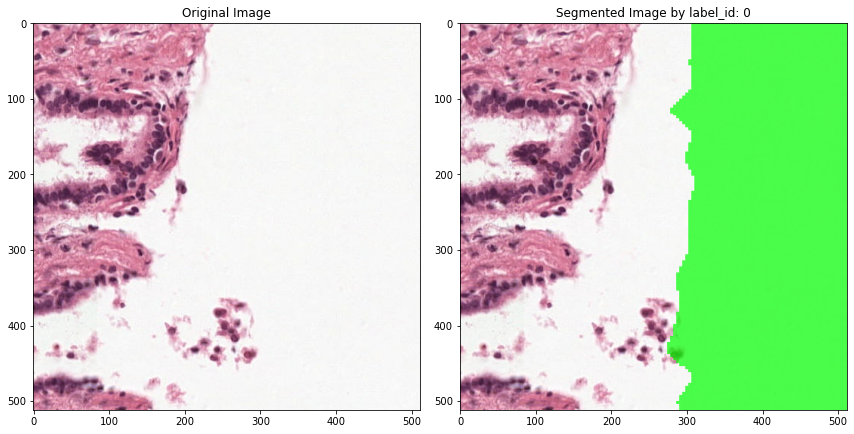

In [621]:
plot_segmented_image_by_label(image = max_entropy_tile,
                              mask = max_entropy_tile_mask,
                              label_id = 0)

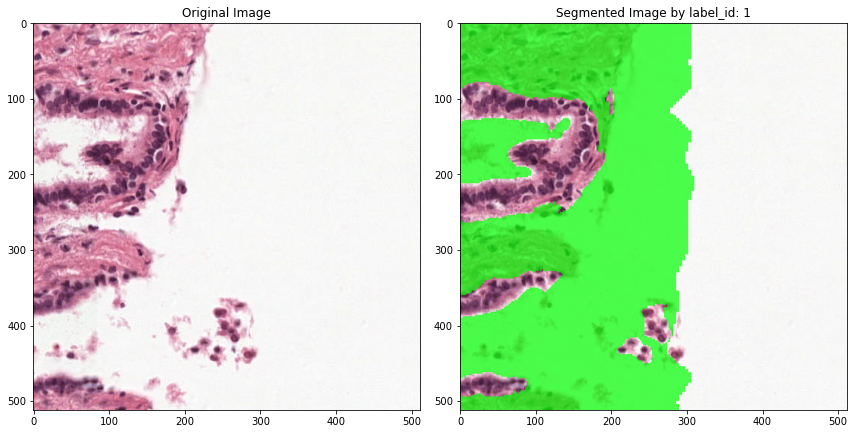

In [622]:
plot_segmented_image_by_label(image = max_entropy_tile,
                              mask = max_entropy_tile_mask,
                              label_id = 1)

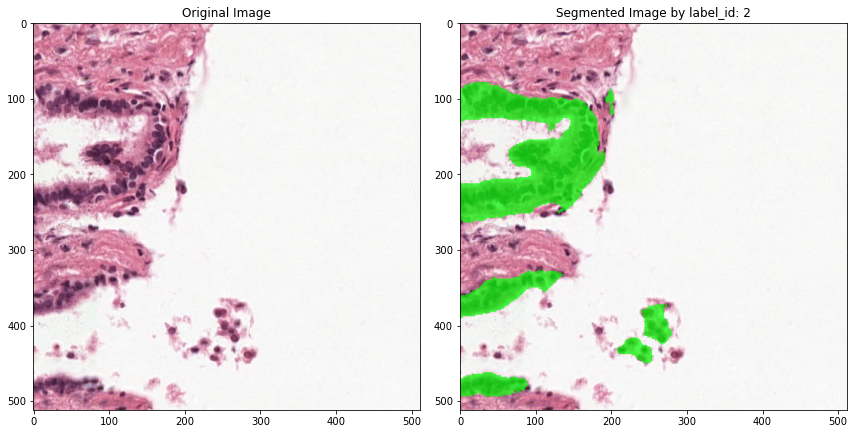

In [623]:
plot_segmented_image_by_label(image = max_entropy_tile,
                              mask = max_entropy_tile_mask,
                              label_id = 2)

### 9. Write function to apply segment to image by a label

In [624]:
def apply_segment_to_image_by_label(image,
                                    mask,
                                    label_id,
                                    color_lst):
    
    """
    Function to apply segmentation mask to image
    for a specific label_id
    
    Parameters
    -----------
    image: np.ndarray
        The image to which the segmentation mask is to
        be applied for that specific label_id
    
    mask: np.ndarray
        The mask which is to be applied to the image
        where the label_id is present
    
    label_id: int
        The label_id that is to be applied to the
        image from the segmentation mask
    
    color_lst: List[int]
        The color, expressed as list of RGB integer values,
        to be applied to the image where the label_id is
        present in the corresponding segmentation mask
    
    Returns
    --------
    np.ndarray
        The image with the segmentation mask applied
        at the pixel locations where label_id is present
        
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    #assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d, color_rgb_list = color_lst)
    
    return segmented_image

### 10. Write function to apply segment to image by multiple labels

In [626]:
def apply_segment_to_image_by_multiple_labels(image: np.ndarray,
                                              mask: np.ndarray,
                                              label_ids: List[int],
                                              color_rgb_pixels: List[list[int,int,int]] = [[0, 255, 0],
                                                                                           [255, 0, 0],
                                                                                           [0, 0, 255],
                                                                                           [255, 255, 0],
                                                                                           [255, 0, 255],
                                                                                           [0, 255, 255],
                                                                                           [255, 165, 0],
                                                                                           [128, 0, 128]],
                                              colors: List[str] = ["green",
                                                                    "red",
                                                                    "blue",
                                                                    "yellow",
                                                                    "magenta",
                                                                     "cyan",
                                                                    "orange",
                                                                     "purple"]) -> np.ndarray:
    
    for i in range(len(label_ids)):
        image = apply_segment_to_image_by_label(image = image,
                                                mask = mask,
                                                label_id = label_ids[i],
                                                color_lst = color_rgb_pixels[i])
    
    return image

### 11. Write function to generate segmentation mask by K-Means algorithm

In [627]:
def generate_kmeans_segmentation_mask(image: np.ndarray,
                                      mask: np.ndarray,
                                      k: Union[None, int] = None):
    
    if k is None:
        k = len(putil.enlist_class_presence(mask))
        
    image_size = image.shape[0]
    n_channels = image.shape[-1]
    
    pixels = image.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    
    labels = kmeans.labels_
    
    kmeans_segmentation_mask = labels.reshape(image_size, image_size)
    
    processed_kmeans_segmentation_mask = np.zeros((image_size, image_size, n_channels))
    processed_kmeans_segmentation_mask[:, :, 0] = kmeans_segmentation_mask
    
    return processed_kmeans_segmentation_mask

### 12. Write function to normalize tile

In [628]:
def normalize_tile(tile,
                   min_vals = [0,0,0],
                   max_vals = [255,255,255]):
    
    assert tile.shape[-1] == 3
    
    if not torch.is_tensor(min_vals):
        min_vals = torch.tensor(min_vals)
    if not torch.is_tensor(max_vals):
        max_vals = torch.tensor(max_vals)
    
    normalizer = ChannelWiseMinMaxNormalizer(min_values = min_vals,
                                             max_values = max_vals)
    tile = torch.tensor(tile)
    tile = tile.unsqueeze(0).permute(0, 3, 1, 2)
    tile = normalizer.transform(tile)
    tile = tile.squeeze(0).permute(1,2,0)
    
    return tile.numpy()

### 13. Write function to plot results obtained from ground truth segmentation and k means algorithm

In [629]:
def plot_ground_truth_kmeans_segmentation_results(input_image: np.ndarray,
                                                  input_mask: np.ndarray,
                                                  tile_size: int = 224):
    
    max_entropy, min_entropy, max_entropy_tile, max_entropy_tile_mask, _ = mine_highest_entropy_tile(image = input_image,
                                                                                                     mask = input_mask,
                                                                                                     tile_size = tile_size)

    normalized_max_entropy_tile = normalize_tile(max_entropy_tile)

    label_ids = list(putil.enlist_class_presence(max_entropy_tile_mask))

    ground_truth_segmented_image = apply_segment_to_image_by_multiple_labels(image = max_entropy_tile,
                                                                             mask = max_entropy_tile_mask,
                                                                             label_ids = label_ids)


    processed_kmeans_segmentation_mask = generate_kmeans_segmentation_mask(image = normalized_max_entropy_tile,
                                                                           mask = max_entropy_tile_mask,
                                                                           k = len(label_ids))

    kmeans_segmented_image = apply_segment_to_image_by_multiple_labels(image = max_entropy_tile,
                                                                       mask = processed_kmeans_segmentation_mask,
                                                                       label_ids = label_ids)


    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(max_entropy_tile)
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  

    ax[1].imshow(ground_truth_segmented_image)
    ax[1].set_title(f'Ground Truth Segmented Image')  
    ax[1].axis('off')  

    ax[2].imshow(kmeans_segmented_image)
    ax[2].set_title(f'K-Means Segmented Image')  
    ax[2].axis('off')  


    plt.tight_layout()

    plt.show()

### 14. Apply K-means clustering to maximum entropy tiles sized 224 by 224 from different images and plot results alongside ground truth segmentation mask

Number of 224-sized tiles scanned: 2938
Not all available classes in mask are represented in the maximum entropy tile


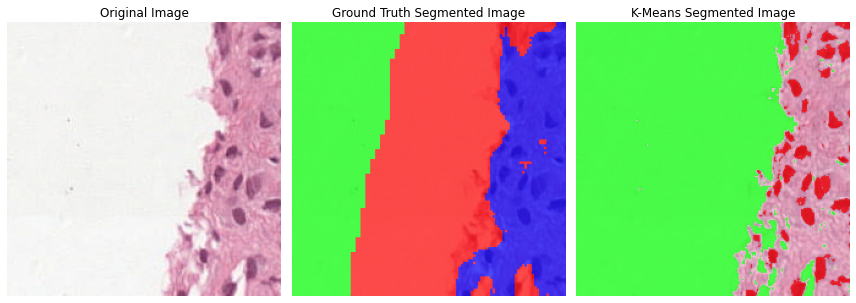

In [630]:
mask_file = mask_files[0]
image_file = image_files[0]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 3600


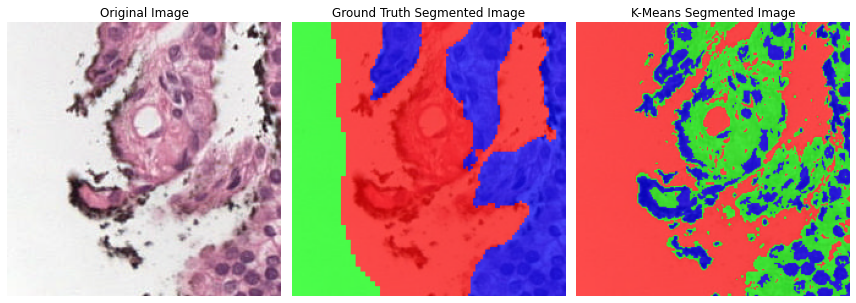

In [631]:
mask_file = mask_files[1]
image_file = image_files[1]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 1380
Not all available classes in mask are represented in the maximum entropy tile


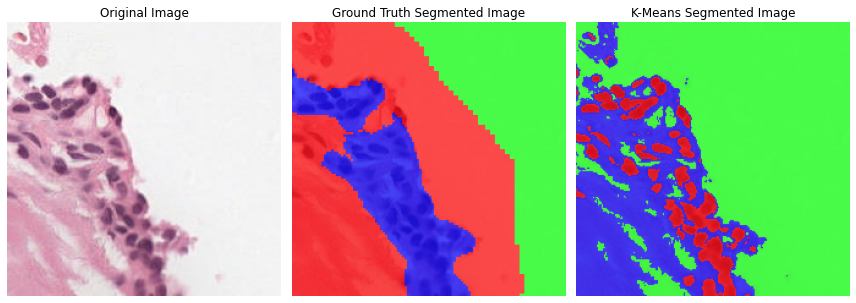

In [632]:
mask_file = mask_files[2]
image_file = image_files[2]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 306


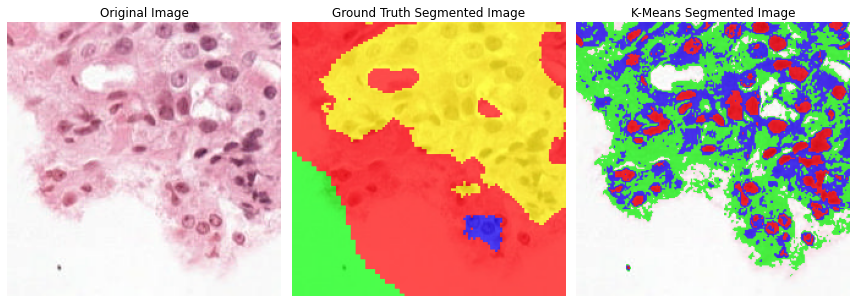

In [633]:
mask_file = mask_files[3]
image_file = image_files[3]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 4536


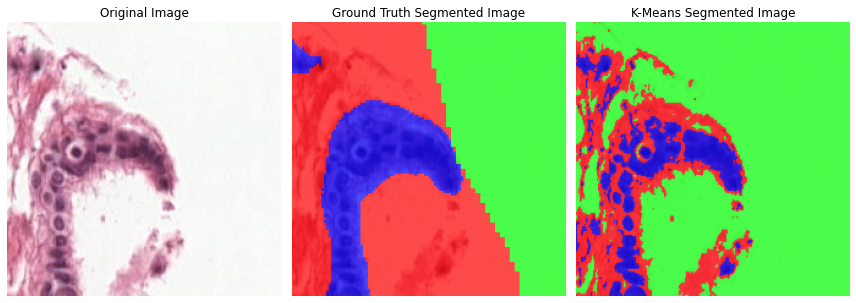

In [634]:
mask_file = mask_files[4]
image_file = image_files[4]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 3432
Not all available classes in mask are represented in the maximum entropy tile


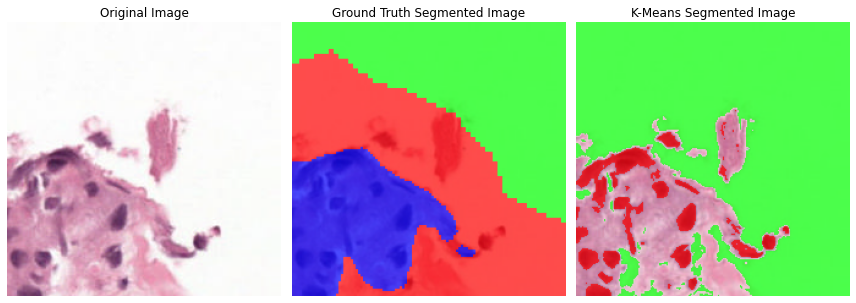

In [635]:
mask_file = mask_files[5]
image_file = image_files[5]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 4028
Not all available classes in mask are represented in the maximum entropy tile


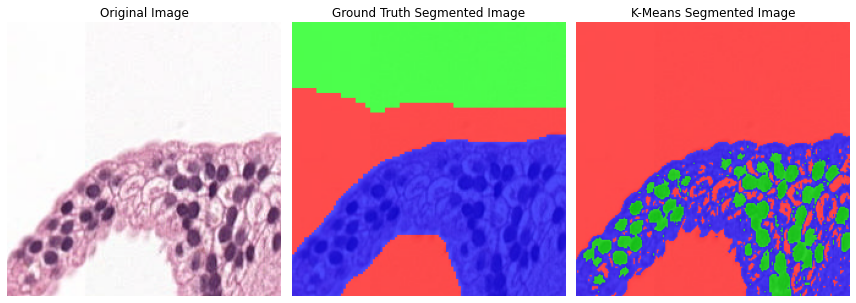

In [636]:
mask_file = mask_files[6]
image_file = image_files[6]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 7776
Not all available classes in mask are represented in the maximum entropy tile


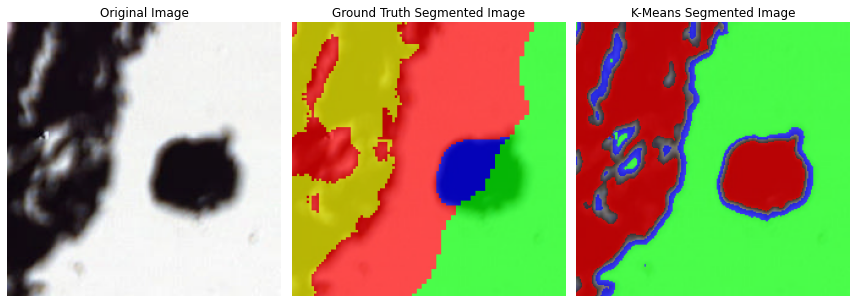

In [637]:
mask_file = mask_files[7]
image_file = image_files[7]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 1836
Not all available classes in mask are represented in the maximum entropy tile


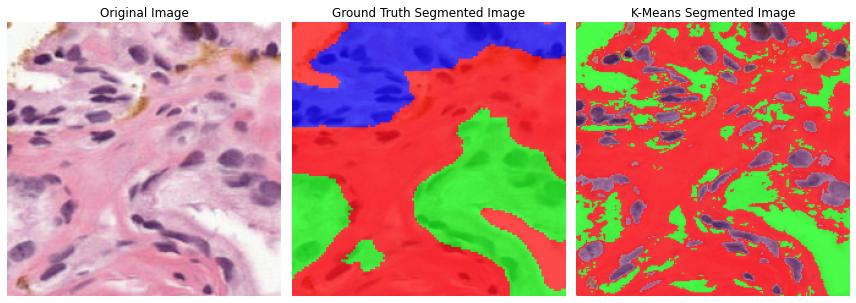

In [638]:
mask_file = mask_files[8]
image_file = image_files[8]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 7636
Not all available classes in mask are represented in the maximum entropy tile


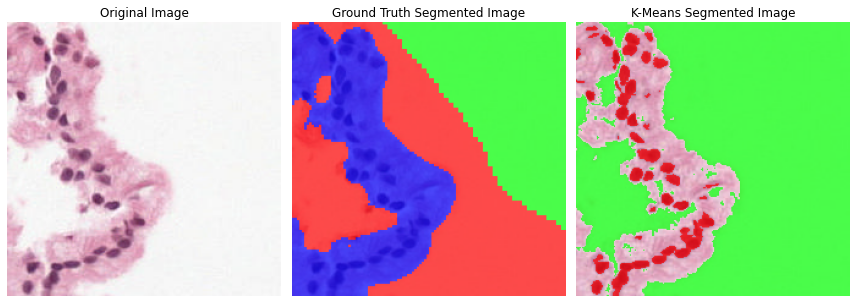

In [639]:
mask_file = mask_files[9]
image_file = image_files[9]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

### 15. Apply K-means clustering to maximum entropy tiles sized 512 by 512 from different images and plot results alongside ground truth segmentation mask

Number of 512-sized tiles scanned: 539
Not all available classes in mask are represented in the maximum entropy tile


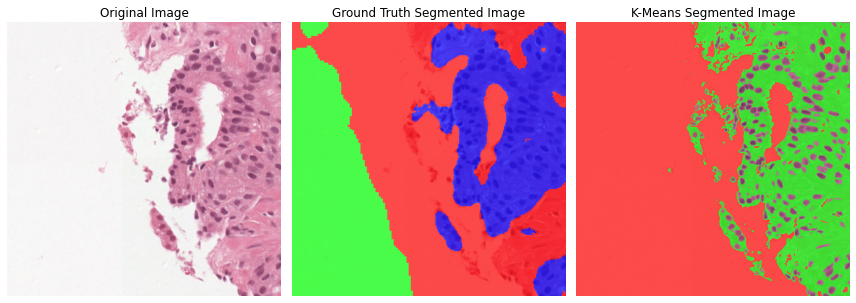

In [641]:
mask_file = mask_files[0]
image_file = image_files[0]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 704


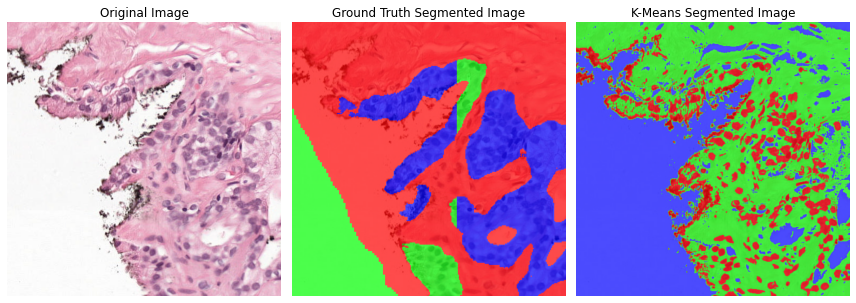

In [642]:
mask_file = mask_files[1]
image_file = image_files[1]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 260
Not all available classes in mask are represented in the maximum entropy tile


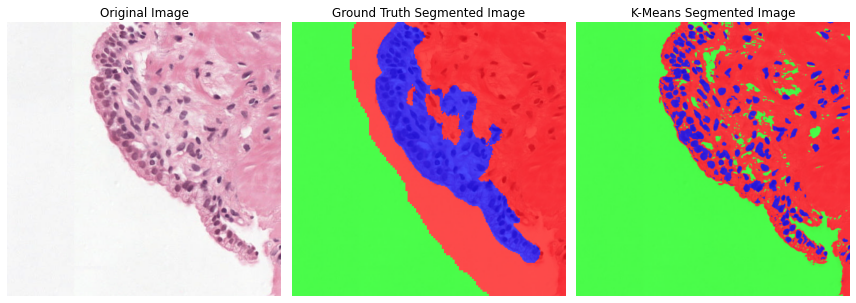

In [643]:
mask_file = mask_files[2]
image_file = image_files[2]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 60
Not all available classes in mask are represented in the maximum entropy tile


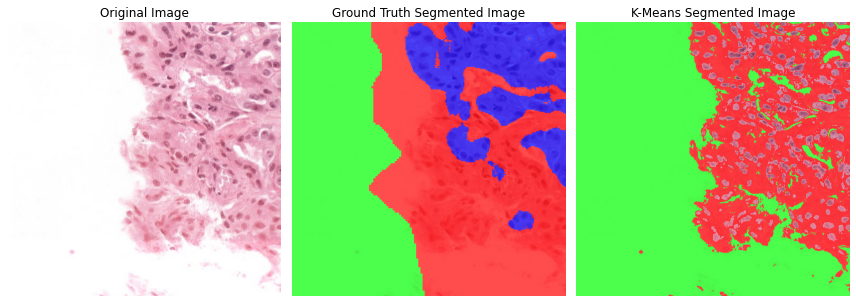

In [644]:
mask_file = mask_files[3]
image_file = image_files[3]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 846


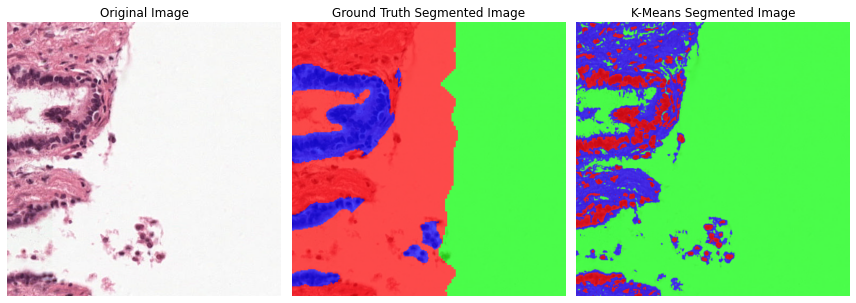

In [645]:
mask_file = mask_files[4]
image_file = image_files[4]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 667
Not all available classes in mask are represented in the maximum entropy tile


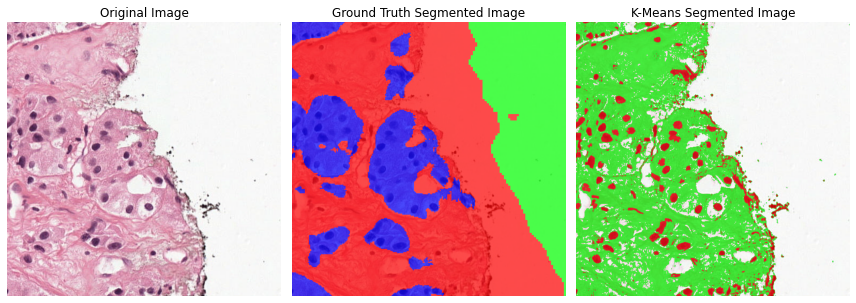

In [646]:
mask_file = mask_files[5]
image_file = image_files[5]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 782
Not all available classes in mask are represented in the maximum entropy tile


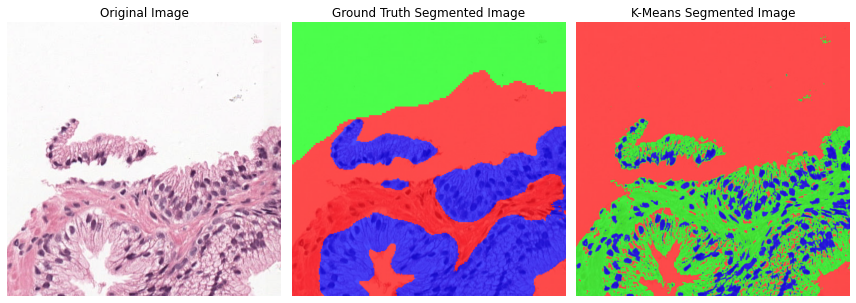

In [647]:
mask_file = mask_files[6]
image_file = image_files[6]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 352
Not all available classes in mask are represented in the maximum entropy tile


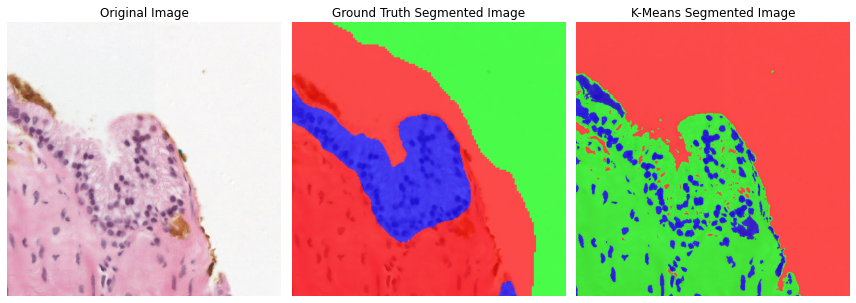

In [649]:
mask_file = mask_files[8]
image_file = image_files[8]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 512-sized tiles scanned: 1440
Not all available classes in mask are represented in the maximum entropy tile


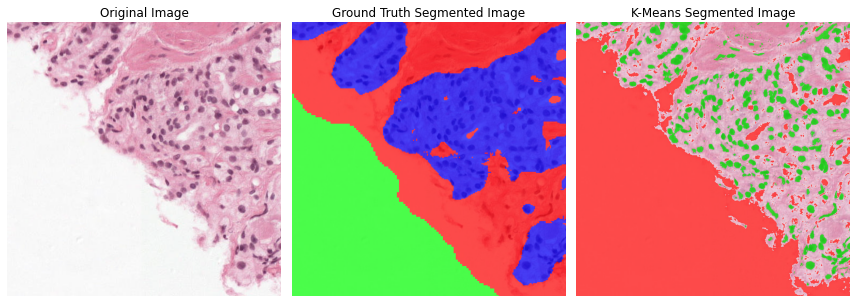

In [650]:
mask_file = mask_files[9]
image_file = image_files[9]
tile_size = 512


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_kmeans_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)